In [6]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import numpy as np
from numpy.typing import ArrayLike
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skipper_image_analysis.utils import (
    prepare_frame, filtro_dipolos
)

def intensidad_func(tph, tau, Pc):
    npump = 3000
    n = 8
    return npump*Pc*(np.exp(-tph/tau) - np.exp(-n*tph/tau))


def tau_func(T, e_kb, tau_0):
    return tau_0/(T**2)*np.exp(e_kb/T)


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


# CARPETAS_POR_TEMP: dict[str, list[str]] = {
#     # 127: [
#     #     "skipper_data/TRAPS/19NOV2023_127K/",
#     #     "skipper_data/TRAPS/20NOV2023_127K/",
#     # ],
#     135: ["skipper_data/TRAPS/27NOV2023_135K/"],
#     140: ["skipper_data/TRAPS/23NOV2023_140K/"],
#     145: ["skipper_data/TRAPS/25NOV2023_145K/"],
#     150: ["skipper_data/TRAPS/22NOV2023_150K/"],
#     160: ["skipper_data/TRAPS/12DIC2023_160K/"],
#     165: [
#         # "skipper_data/TRAPS/06DIC2023_165K/",
#         "skipper_data/TRAPS/07DIC2023_165K/",
#         "skipper_data/TRAPS/09DIC2023_165K/",
#     ],
# }
CARPETAS_POR_TEMP: dict[str, list[str]] = {
    126: [
        "skipper_data/TRAPS/02JUN2024_126K_EXP30s_LED_30s",
    ],
    127: [
        "skipper_data/TRAPS/06MAY2024_127K_LED_30s",
    ],
    130: [
        "skipper_data/TRAPS/01JUN2024_130K_EXP30s_LED_30s",
    ],
    135: [
        "skipper_data/TRAPS/02JUN2024_135K_EXP30s_LED_30s",
    ],
    140: [
        "skipper_data/TRAPS/01JUN2024_140K_EXP30s_LED_30s",
    ],
    145: [
        "skipper_data/TRAPS/02JUN2024_145K_EXP30s_LED_30s",
    ],
    151: [
        "skipper_data/TRAPS/31MAY2024_151K_EXP30s_LED_30s",
    ],
    152: [
        "skipper_data/TRAPS/03JUN2024_152p5K_EXP30s_LED_30s",
    ],
    160: [
        "skipper_data/TRAPS/03JUN2024_160K_EXP30s_LED_30s",
    ],
    166: [
        "skipper_data/TRAPS/03JUN2024_166K_EXP30s_LED_30s",
    ],
    171: [
        "skipper_data/TRAPS/04JUN2024_171K_EXP30s_LED_30s",
    ],
    172: [
        "skipper_data/TRAPS/04JUN2024_172K_EXP30s_LED_30s",
    ],
    180: [
        "skipper_data/TRAPS/19AUG2024_180K_EXP30s_LED_30s",
    ],
    190: [
        "skipper_data/TRAPS/19AUG2024_190K_EXP30s_LED_30s",
    ],
    195: [
        "skipper_data/TRAPS/19AUG2024_195K_EXP30s_LED_30s",
    ]
}
DATA_DIR_COUNT = sum([len(dir_list) for dir_list in CARPETAS_POR_TEMP.values()])
RESULTS_DIR = "skipper_image_analysis/TRAPS_results_normalized"
CLOCKS_TO_SEC = 15e6  # Hz
DTPH_VALS = np.array([50, 75, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600, 38400, 51200, 76800])
# Define Bins so that each value is at the center of the bin in a log scale
DTPH_BINS = np.sqrt(DTPH_VALS[1:] * DTPH_VALS[:-1])
DTPH_BINS = np.insert(DTPH_BINS, 0, DTPH_VALS[0]*0.8)
DTPH_BINS = np.append(DTPH_BINS, DTPH_VALS[-1]*1.2)

temp_colors = plt.cm.ScalarMappable(
    norm=plt.Normalize(127, 191),
    cmap="plasma"
)
dtph_colors = plt.cm.ScalarMappable(
    norm=LogNorm(DTPH_VALS[0]/CLOCKS_TO_SEC, DTPH_VALS[-1]/CLOCKS_TO_SEC),
    cmap="viridis"
)

In [7]:
def carga_archivos(
    temperatura: int, dir_idx: int, frame_idx: int,
    threshold_factor: float = 3, corte_simetria: float = 20
) -> tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]:
    """Carga los archivos de una carpeta de una temperatura y un número de archivo \
específicos. Luego, aplica el filtro de dipolos a cada frame y devuelve las \
coordenadas de los dipolos, los valores de los dipolos, una máscara con los dipolos \
encontrados, el objeto fits con los datos de la CCD en la última imagen procesada y \
un diccionario con los errores de cada frame.

    Parameters:
    -----------

        `temperatura {int}`: Temperatura de la CCD en Kelvin durante la toma de datos.

        `dir_idx {int}`: Índice de la carpeta con los archivos a cargar cuando existe \
más de una carpeta por temperatura.

        `frame_idx {int}`: Índice del frame/cuadrante de la CCD a analizar.

        `threshold_factor {float, optional}`: Factor por el que se multiplica al \
ancho de la distribución de carga en la CCD para calcular el umbral de selección. Es \
decir, un dipolo se considera válido si su autocorrelación es menor que \
`-(threshold_factor * ancho_dist)**2`, donde `ancho_dist` es el ancho de la distribución \
de carga en la CCD. Valor por defecto = 3.

        `corte_simetria {float, optional}`: Porcentaje de la diferencia en simetría \
para el filtro en la detección de dipolos. Valor por defecto = 20.

    Returns:
    --------

        `{tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]}`: Diccionarios\
 con las coordenadas de los dipolos, los valores de los dipolos, una máscara con los \
dipolos encontrados, el objeto fits con los datos de la CCD en la última imagen y un \
diccionario con los errores de cada frame.
    """
    global CARPETAS_POR_TEMP
    # Cargar Archivos desde sus Carpetas por Temperatura
    data_dir = CARPETAS_POR_TEMP[temperatura][dir_idx]
    files_in_dir = os.listdir(data_dir)
    valid_formats = ["fits",]
    files_in_dir = [f for f in files_in_dir if (f.rsplit(".")[-1] in valid_formats and "dTph" in f)]
    files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
    frames_dict = dict()
    mediana_dict = dict()
    error_dict = dict()
    coords_dict = dict()
    vals_dict = dict()
    mascara_dipolos = dict()
    for file in tqdm(files_in_dir, desc="Procesando Archivos", leave=True):
        dtph = int(file.rsplit("_")[5][4:])
        if dtph in coords_dict:
            continue
        test_image = fits.open(f'{data_dir}/{file}')
        frames_dict[dtph], mediana_dict[dtph], error_dict[dtph] = prepare_frame(
            test_image, frame_idx
        )  # e⁻
        if error_dict[dtph] > 1e3:  # Si el error es muy grande, descartar el frame
            # Por el NSAMP=20 sabemos que el error de lectura es del orden de 10 e⁻
            del frames_dict[dtph], error_dict[dtph]
            continue
        coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
            frames_dict[dtph], threshold_factor, corte_simetria
        )
    return coords_dict, frames_dict, vals_dict, mediana_dict, error_dict, mascara_dipolos

In [8]:
temperatura = 130  # K
print(f"Temperatura: {temperatura} K")
coords_dict, frames_dict, _, mediana_dict, _, mascara_dipolos = carga_archivos(
    temperatura=temperatura,
    dir_idx=0,  # Siempre 0 salvo para 165 K dónde hay 2 carpetas
    frame_idx=0,  # Variar entre 0 y 1 para ver los cuadrantes iluminados
    threshold_factor=3,  # Variar esto para ver cuantos sigmas se usan para el filtro
    corte_simetria=30,
)

Temperatura: 130 K


Procesando Archivos:   0%|          | 0/22 [00:00<?, ?it/s]

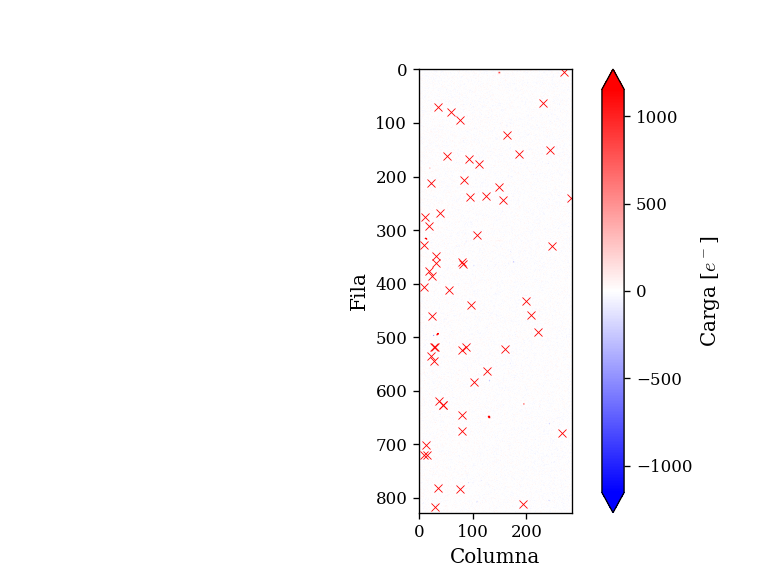

In [9]:
tph_to_plot = DTPH_VALS[2]
# Todo para abajo es solo para el plot
plt.close("all")
%matplotlib widget
fig, ax = plt.subplots(label=f"Temperatura: {temperatura} K, t_ph: {tph_to_plot} clocks")
frame = frames_dict[tph_to_plot]
# ancho_carga = np.std(
#     frame[
#         (np.quantile(frame, 0.005) < frame) & (frame < np.quantile(frame, 0.99))
#     ],
#     ddof=1,
# )
image_cmap = ax.imshow(
    frame,
    cmap="bwr",  # Podes cambiar el cmap para ver en otra escala de colores si preferis
    # vmin=-6*ancho_carga, vmax=6*ancho_carga,  # los colores saturan en 6 sigmas
    vmin=-mediana_dict[tph_to_plot], vmax=mediana_dict[tph_to_plot],
)
x_traps = []
y_traps = []
for coords in coords_dict[tph_to_plot]:
    fila, columna = coords[1]  # Coordenadas del píxel vacío del dipolo
    x_traps.append(columna)
    y_traps.append(fila)
ax.plot(x_traps, y_traps, "x", mec="r", mfc="none", ms=5, mew=0.5)
ax.set_xlabel("Columna")
ax.set_ylabel("Fila")
fig.colorbar(image_cmap, label="Carga [$e^-$]", ax=ax, extend="both")
plt.show()